# Hyperparameter Tuning - Analysis

**[Pier Paolo Ippolito](https://www.linkedin.com/in/pierpaolo28/)**

In this example is used data taken from the [2015 Flight Delays and Cancellations](https://www.kaggle.com/usdot/flight-delays) dataset. The preprocessing of this data is available in the "Hyperparameter Tuning in Tourism - Preprocessing" notebook. In this notebook, we are going to make use of the created dataset in order to perform a regression analysis (LASSO Regression) to predict the delay at the arrival of the flight. 

The following Hyperparameter Tuning techniques are going to be taken into account:
- Manual Search
- Grid Search
- Random Search
- Bayesian Optimization
- Genetic Algorithms

![](jerry-zhang-unsplash.jpg)

<span>Photo by <a href="https://unsplash.com/@z734923105?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Jerry Zhang</a> on <a href="https://unsplash.com/s/photos/flight?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Unsplash</a></span>

## Data Preprocessing

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [2]:
#df = pd.read_csv('/kaggle/input/flight-data/flight_data.csv')
df = pd.read_csv('flight_data.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,...,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIRLINE
0,1,1,4,98,N407AS,ANC,SEA,5,2354.0,-11.0,...,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,Alaska Airlines Inc.
1,1,1,4,108,N309AS,ANC,SEA,45,41.0,-4.0,...,173.0,1448,451.0,4.0,509,455.0,-14.0,0,0,Alaska Airlines Inc.
2,1,1,4,134,N464AS,ANC,SEA,155,140.0,-15.0,...,170.0,1448,547.0,11.0,633,558.0,-35.0,0,0,Alaska Airlines Inc.
3,1,1,4,114,N303AS,ANC,SEA,220,209.0,-11.0,...,176.0,1448,620.0,8.0,640,628.0,-12.0,0,0,Alaska Airlines Inc.
4,1,1,4,730,N423AS,ANC,SEA,505,457.0,-8.0,...,179.0,1448,912.0,4.0,930,916.0,-14.0,0,0,Alaska Airlines Inc.


In [3]:
df.shape

(5222000, 24)

In [4]:
df.columns

Index(['MONTH', 'DAY', 'DAY_OF_WEEK', 'FLIGHT_NUMBER', 'TAIL_NUMBER',
       'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE',
       'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'WHEELS_ON',
       'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
       'DIVERTED', 'CANCELLED', 'AIRLINE'],
      dtype='object')

## Data Visualization

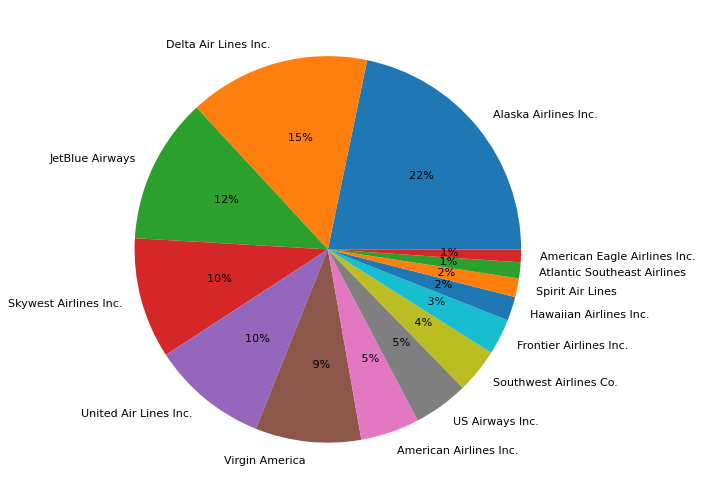

In [5]:
plt.figure(num=None, figsize=(11, 8), dpi=80, facecolor='w', edgecolor='k')
plt.pie(df["AIRLINE"].value_counts(),labels=df["AIRLINE"].unique(), autopct='%4.0f%%')
plt.savefig('bar.svg', format='svg', dpi=1200)
plt.show()

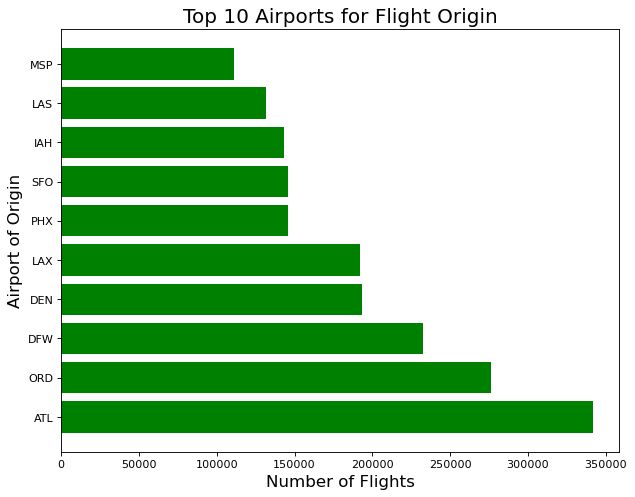

In [6]:
names = df['ORIGIN_AIRPORT'].value_counts()[:10].index
n_flights = df['ORIGIN_AIRPORT'].value_counts()[:10].values
names_pos = [i for i, _ in enumerate(names)]

plt.figure(num=None, figsize=(9, 7), dpi=80, facecolor='w', edgecolor='k')
plt.barh(names_pos, n_flights, color='g')
plt.ylabel("Airport of Origin", fontsize=15)
plt.xlabel("Number of Flights", fontsize=15)
plt.title("Top 10 Airports for Flight Origin", fontsize=18)
plt.yticks(names_pos, names)
plt.savefig('bar2.svg', format='svg', dpi=1200)
plt.show()

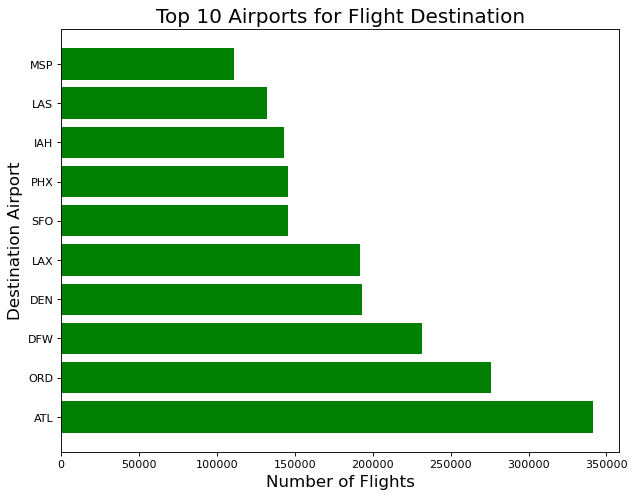

In [7]:
names = df['DESTINATION_AIRPORT'].value_counts()[:10].index
n_flights = df['DESTINATION_AIRPORT'].value_counts()[:10].values
names_pos = [i for i, _ in enumerate(names)]

plt.figure(num=None, figsize=(9, 7), dpi=80, facecolor='w', edgecolor='k')
plt.barh(names_pos, n_flights, color='g')
plt.ylabel("Destination Airport", fontsize=15)
plt.xlabel("Number of Flights", fontsize=15)
plt.title("Top 10 Airports for Flight Destination", fontsize=18)
plt.yticks(names_pos, names)
plt.savefig('bar3.svg', format='svg', dpi=1200)
plt.show()

## Machine Learning

Converting categorical data into numeric using LabelEncoder and standardizing our features by removing the overall mean and scaling to the unit variance. In order to test the different Hyperparameter Tuning approaches, a Lasso Regression model is going to be taken into account with a train-test split of 70% and 30% each and 3-fold cross-validation.
LASSO (Least Absolute Shrinkage Selector Operator) is a particular type of regression technique which aims to reduce our overall residual error by adding a constraint on the parameters so that reduce towards zero the coefficient values of the variables which do not provide almost any value to our model. One of the key parameters of Lasso regression is therefore the weight assigned to the constraint parameter (alpha). The higher the value of alpha and the more weight will have our constraint in our model (if alpha is equal to zero, we would then have a traditional ordinary least square model).  

In [8]:
le = LabelEncoder()
df['TAIL_NUMBER']= le.fit_transform(df['TAIL_NUMBER'])
df['ORIGIN_AIRPORT']= le.fit_transform(df['ORIGIN_AIRPORT'])
df['DESTINATION_AIRPORT']= le.fit_transform(df['DESTINATION_AIRPORT'])
df['ORIGIN_AIRPORT']= le.fit_transform(df['ORIGIN_AIRPORT'])
df['AIRLINE']= le.fit_transform(df['AIRLINE'])
X = df.drop(['ARRIVAL_DELAY'], axis=1)
X = pd.get_dummies(X, prefix_sep='_')
X = StandardScaler().fit_transform(X)
Y = df['ARRIVAL_DELAY']

X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size = 0.30, random_state = 101)

## Default

In [9]:
from sklearn.model_selection import cross_validate

lasso = Lasso()
scores = cross_validate(lasso, X, Y, cv=3, scoring='neg_mean_squared_error')
np.abs(np.mean(scores['test_score']))

97.77544981962599

## Manual Search

The easiest approach to hyperparameter-tuning is to try different values for a hyperparameter and see how these affect our results (e.g. variations in loss/accuracy). Repeating this process a few times, we would then be able to improve our original “guess” by trial and error. In most cases, our original guess will be dictated by our judgment/experience. For example, it can be perfectly reasonable (in some situations) to guess that increasing the batch size or base learning rate might help us in creating more accurate models faster. 

In [10]:
lasso = Lasso(alpha=0.9, max_iter=1500)
scores = cross_validate(lasso, X, Y, cv=3, scoring='neg_mean_squared_error')
np.abs(np.mean(scores['test_score']))

96.8531514084596

## Grid Search

Grid Search can be easily implemented in Python making use of scikit-learn GridSearchCV function. In this case, we just need to specify the model we want to use (Lasso Regression), a dictionary containing the ranges of values we want to get our values from and our loss function of choice. In this implementation the negative mean squared error is specified instead of the mean squared error, since scikit-learn by default aims to maximize rather than minimize our objective function. Additionally, the fit_intercept hyperparameter is introduced in order to test if it is best or not to calculate the intercept for our model.

In Grid Search, we set up a grid of values for each hyperparameter and train/test our model against each possible combination of values. Grid Search is sometimes also referred as “full factorial design”, since it evaluates the Cartesian product for each set of values assigned to each hyperparameter (“Design and Analysis of Experiments, 10th Edition | Wiley,” n.d.). This method can therefore allow us to cover many possible combinations and to explore a good portion of the available optimization search space. One downside to this approach is that it can be extremely computationally expensive (both in terms of time and computing resources needed) compared to other approaches. Because of the curse of dimensionality, this aspect can be fundamentally important if working with many different hyperparameters in a continuous rather than discrete space. For example, if we are optimizing an Artificial Neural Network and we decide to try 7 different values for the number of hidden layers, 3 different learning rates and 2 different activation functions, using Grid Search we will end up training 42 different models (7×3×2). 

In [11]:
from sklearn.model_selection import GridSearchCV

grid_search = {
    'alpha': list(np.linspace(0.7, 2.0, 5, dtype = float)),
    'fit_intercept': ['True', 'False'],
    'max_iter' : list(np.linspace(1000, 1800, 5, dtype = int)),
}

print(grid_search)

{'alpha': [0.7, 1.025, 1.35, 1.675, 2.0], 'fit_intercept': ['True', 'False'], 'max_iter': [1000, 1200, 1400, 1600, 1800]}


In [12]:
clf = Lasso()
model = GridSearchCV(estimator = clf, param_grid = grid_search, scoring='neg_mean_squared_error',
                               cv = 3, verbose= 5, n_jobs = -1)
model.fit(X_Train,Y_Train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  8.0min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.7, 1.025, 1.35, 1.675, 2.0],
                         'fit_intercept': ['True', 'False'],
                         'max_iter': [1000, 1200, 1400, 1600, 1800]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=5)

In [13]:
model.best_params_

{'alpha': 0.7, 'fit_intercept': 'True', 'max_iter': 1000}

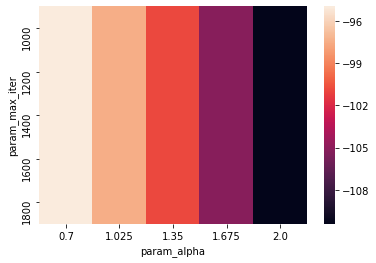

In [18]:
table = pd.pivot_table(pd.DataFrame(model.cv_results_),
    values='mean_test_score', index='param_max_iter', 
                       columns='param_alpha')
     
sns.heatmap(table)
plt.savefig('bar4.svg', format='svg', dpi=1200)

In [19]:
predictions = model.best_estimator_.predict(X_Test)
mean_squared_error(Y_Test, predictions)

95.25140966332542

## Random Search

Using Grid Search, we were therefore able again to reduce our overall loss. We can now repeat this same procedure using instead Random Search and focusing our search area around the best hyperparameter set identified so far in order to see if is possible to reduce even more our loss.

In order to try to overcome the limitations of Grid Search, Random Search has been created. In Random Search, we randomly sample different possible hyperparameters combinations from our search space. This approach has been demonstrated to be more efficient than traditional manual and grid search approaches if some hyperparameters have more weight compared to the others (Bergstra, Ca, & Ca, 2012 and Hutter, Hoos, Leyton-Brown, & Ca, n.d.). Random Search can therefore allow us to achieve similar results to Grid Search while considerably reducing the associated computational requirements. One possible downside of using Random Search, is that we have no control on how the different values are selected, therefore making it more difficult to understand why some parameters might work better than others.

In [15]:
from sklearn.model_selection import RandomizedSearchCV

random_search = {
    'alpha': list(np.linspace(0.3, 1.5, 5, dtype = float)),
    'fit_intercept': ['True', 'False'],
    'max_iter' : list(np.linspace(700, 1200, 5, dtype = int)),
}

clf = Lasso()
model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, scoring='neg_mean_squared_error',
                               cv = 3, verbose= 5, random_state= 101, n_jobs = -1)
model.fit(X_Train,Y_Train)

model.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.0min finished


{'max_iter': 825, 'fit_intercept': 'True', 'alpha': 0.3}

In [16]:
predictions = model.best_estimator_.predict(X_Test)
mean_squared_error(Y_Test, predictions)

18.175967887697357

## Bayesian Optimization

In this example, the hyperopt library (Bergstra, Yamins, & Cox, 2013) is going to be used in order to implement our Bayesian Optimization routine. Alternative libraries are also available in Python such as Optuna (Akiba, Sano, Yanase, Ohta, & Koyama, 2019).
Hyperopt can make easy to implement Bayesian Optimization by just calling the fmin() function and specifying its key 3 parameters:
1.	Objective Function: our chosen loss function to minimize.
2.	Domain Space: the range of different hyperparameter values to test.
3.	Optimization Algorithm: search algorithm used to find the best hyperparameter values to use.

Bayesian Optimization is a hyperparameter tuning technique created in the hope to take “the human out of the loop”. In fact, using this approach, all the different hyperparameter values are automatically determined without needing human intervention. This technique has been extensively used in the past few years in order to achieve state-of-the-art performances in areas such as Image and Speech Recognition (Snoek, Larochelle, & Adams, n.d., Snoek et al., 2015, Dahl, Sainath, & Hinton, n.d.). Furthermore, several studies demonstrated how Bayesian Optimization can reliably provide in many applications better results than Random Search (Bergstra, Yamins, & Cox, 2013, Bergstra, Bardenet, Bengio, & Kégl, n.d.).
Bayesian Optimization is part of a class of algorithms commonly referred as sequential model-based optimization (SMBO). The key difference between this type of technique and Grid/Random Search, is that in this case, we iteratively make use of past experimentations in order to best understand what values for the hyperparameters might be best to try and avoid (making us focus only on the most promising combinations). In this way, Bayesian Optimization tends usually to converge faster to an optimal/sub-optimal solution rather than Grid/Random Search (we automatically pay less attention to areas of the search space which don’t seem to provide any added value).

In [17]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

space = {
    'alpha': hp.quniform('alpha', 0.3, 1.5, 5),
    'fit_intercept': hp.choice('fit_intercept', ['True', 'False']),
    'max_iter': hp.quniform('max_iter', 700, 1200, 5)
}

def objective(space):
    model = Lasso(alpha = space['alpha'],
                  fit_intercept = space['fit_intercept'],
                  max_iter = space['max_iter'])
    
    loss = cross_val_score(model, X_Train, Y_Train, cv = 3, scoring='neg_mean_squared_error').mean()
    return {'loss': -loss, 'status': STATUS_OK }


trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 30,
            trials= trials)
best

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531:

  3%|▎         | 1/30 [01:14<35:55, 74.32s/trial, best loss: 0.001970346974059133]

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531:

  7%|▋         | 2/30 [02:31<35:01, 75.06s/trial, best loss: 0.001970346974059133]

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531:

 10%|█         | 3/30 [03:47<34:01, 75.61s/trial, best loss: 0.001970346974059133]

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531:

 13%|█▎        | 4/30 [05:06<33:10, 76.56s/trial, best loss: 0.001970346974059133]

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531:

 17%|█▋        | 5/30 [06:27<32:21, 77.67s/trial, best loss: 0.001970346974059133]

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531:

 20%|██        | 6/30 [07:46<31:15, 78.13s/trial, best loss: 0.001970346974059133]

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531:

 23%|██▎       | 7/30 [09:06<30:10, 78.73s/trial, best loss: 0.001970346974059133]

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531:

 27%|██▋       | 8/30 [10:28<29:17, 79.88s/trial, best loss: 0.001970346974059133]

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531:

 30%|███       | 9/30 [11:48<27:58, 79.92s/trial, best loss: 0.001970346974059133]

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531:

 33%|███▎      | 10/30 [13:08<26:33, 79.68s/trial, best loss: 0.001970346974059133]

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531:

 37%|███▋      | 11/30 [14:24<24:54, 78.65s/trial, best loss: 0.001970346974059133]

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531:

 40%|████      | 12/30 [15:41<23:27, 78.21s/trial, best loss: 0.001970346974059133]

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531:

 43%|████▎     | 13/30 [16:58<22:02, 77.80s/trial, best loss: 0.001970346974059133]

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531:

 47%|████▋     | 14/30 [18:14<20:37, 77.33s/trial, best loss: 0.001970346974059133]

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531:

 50%|█████     | 15/30 [19:31<19:19, 77.27s/trial, best loss: 0.001970346974059133]

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531:

 53%|█████▎    | 16/30 [20:48<17:57, 77.00s/trial, best loss: 0.001970346974059133]

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531:

 57%|█████▋    | 17/30 [22:04<16:38, 76.79s/trial, best loss: 0.001970346974059133]

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531:

 60%|██████    | 18/30 [23:23<15:28, 77.36s/trial, best loss: 0.001970346974059133]

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531:

 63%|██████▎   | 19/30 [24:40<14:11, 77.37s/trial, best loss: 0.001970346974059133]

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531:

 67%|██████▋   | 20/30 [25:57<12:53, 77.37s/trial, best loss: 0.001970346974059133]

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531:

 70%|███████   | 21/30 [27:16<11:40, 77.80s/trial, best loss: 0.001970346974059133]

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531:

 73%|███████▎  | 22/30 [28:32<10:18, 77.33s/trial, best loss: 0.001970346974059133]

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531:

 77%|███████▋  | 23/30 [29:48<08:57, 76.85s/trial, best loss: 0.001970346974059133]

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531:

 80%|████████  | 24/30 [31:04<07:39, 76.53s/trial, best loss: 0.001970346974059133]

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531:

 83%|████████▎ | 25/30 [32:20<06:21, 76.37s/trial, best loss: 0.001970346974059133]

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531:

 87%|████████▋ | 26/30 [33:38<05:07, 76.95s/trial, best loss: 0.001970346974059133]

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531:

 90%|█████████ | 27/30 [34:54<03:49, 76.57s/trial, best loss: 0.001970346974059133]

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531:

 93%|█████████▎| 28/30 [36:10<02:33, 76.55s/trial, best loss: 0.001970346974059133]

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531:

 97%|█████████▋| 29/30 [37:28<01:16, 76.92s/trial, best loss: 0.001970346974059133]

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531:

100%|██████████| 30/30 [38:46<00:00, 77.56s/trial, best loss: 0.001970346974059133]


{'alpha': 0.0, 'fit_intercept': 1, 'max_iter': 1125.0}

In [18]:
fit_intercept = {0: 'True', 1: 'False'}

print(fit_intercept[best['fit_intercept']])

False


In [20]:
model = Lasso(alpha = best['alpha'], 
              fit_intercept = fit_intercept[best['fit_intercept']], 
              max_iter = best['max_iter']).fit(X_Train,Y_Train)

predictions = model.predict(X_Test)
mean_squared_error(Y_Test, predictions)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)


0.001996175729487521

In [24]:
lasso = Lasso(alpha = best['alpha'], 
              fit_intercept = fit_intercept[best['fit_intercept']], 
              max_iter = best['max_iter'])
scores = cross_validate(lasso, X, Y, cv=3, scoring='neg_mean_squared_error')
np.abs(np.mean(scores['test_score']))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: Use

0.0021410091012527784

## Genetic Algorithms

We are now ready to test Genetic Algorithms as our last approach. In this case, the TPOT Auto Machine Learning library (Olson et al., 2016) is going to be our library of choice. This library is in fact based on the scikit-learn library and it can be used for either regression or classification tasks.

Genetic Algorithms are a class of hyperparameter tuning techniques inspired by the Darwinian process of Natural Selection. For evolution to take place, we need at least 4 conditions to be met:
1.	Reproduction: to perpetuate their species, organisms need to be able to generate offspring.
2.	Heredity: generated offspring need to be able to inherit different characteristics from their parents. 
3.	Variation: a population should be formed by individuals with unique characteristics (there needs to be some form of variety between the different individual)
4.	Change in fitness: the reproductive success of each individual (fitness) is dependent on the differences between them and the other members of the population.

To exemplify an evolutionary process, let us imagine we have a population of N Machine Learning models and each of them has different unique values for their hyperparameters. At this point, we calculate the performance of each model and keep just the top N/2 performing models (the most promising ones). In order to try to improve our population, we can now create other N/2 models by using similar (but different) hyperparameters to the ones of the top performing models. This would then leave us again with a population of N models. Repeating this process iteratively, would then allow us to gradually increase the overall performance of our population of models’ iteration by iteration. 
Although, using Genetic Algorithms different hyperparameters needs still to be specified such as our original population size, the proportion of offspring which must change their hyperparameters each iteration, etc. 

In [23]:
from tpot import TPOTRegressor
from deap.gp import Primitive

parameters = {
    'alpha': list(np.linspace(0.3, 1.5, 5, dtype = float)),
    'fit_intercept': ['True', 'False'],
    'max_iter' : list(np.linspace(700, 1200, 5, dtype = int)),
}

tpot_regressor = TPOTRegressor(generations= 5, population_size= 24, offspring_size= 12,
                                 verbosity= 2, early_stop= 12,
                                 config_dict={'sklearn.linear_model.Lasso': parameters}, 
                                 cv = 3, scoring = 'neg_mean_squared_error')
tpot_regressor.fit(X_Train,Y_Train)


Generation 1 - Current best internal CV score: -7.398649655547609

Generation 2 - Current best internal CV score: -7.398649655547609

Generation 3 - Current best internal CV score: -7.228131062904847

Generation 4 - Current best internal CV score: -7.228131062904847

Generation 5 - Current best internal CV score: -7.228131062904847

Best pipeline: Lasso(Lasso(Lasso(input_matrix, alpha=0.3, fit_intercept=True, max_iter=1075), alpha=0.6, fit_intercept=True, max_iter=950), alpha=0.3, fit_intercept=True, max_iter=1200)


TPOTRegressor(config_dict={'sklearn.linear_model.Lasso': {'alpha': [0.3, 0.6,
                                                                    0.8999999999999999,
                                                                    1.2, 1.5],
                                                          'fit_intercept': ['True',
                                                                            'False'],
                                                          'max_iter': [700, 825,
                                                                       950,
                                                                       1075,
                                                                       1200]}},
              cv=3, early_stop=12, generations=5, offspring_size=12,
              population_size=24, scoring='neg_mean_squared_error',
              verbosity=2)

In [54]:
res = np.abs(tpot_regressor.score(X_Test, Y_Test))
print(res)

7.2407980915148595


In this case, Bayesian Optimization was the method which performed best for this type of task. Although, the results obtained are highly dependent on the chosen grid space and dataset used. Therefore, in different situations, different optimization techniques will perform better than others.